<hr style="border:0.2px solid black"> </hr>

<figure>
  <IMG SRC="img/ntnu_logo.png" WIDTH=250 ALIGN="right">
</figure>

**<ins>Course:</ins>** TVM4174 - Hydroinformatics for Smart Water Systems

# <ins>Example:</ins> Clustering Methods and Tools
    
*Developed by David Steffelbauer*

<hr style="border:0.2px solid black"> </hr>

    
## k-Means Clustering with scikit-learn



In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
sns.set_style('darkgrid')
colors = sns.color_palette('plasma', 8)
import matplotlib as mpl
from cycler import cycler
mpl.rcParams['axes.prop_cycle'] = cycler(color=colors)
pd.plotting.register_matplotlib_converters()

In [2]:
def plotting_clusters(data, labels=None, centers=None, cs='w'):
    
    if isinstance(data, pd.DataFrame):
        data = data.values
    if labels is not None:
        n_clusters = len(set(labels))
        colors = sns.color_palette('plasma', n_clusters)
        cs = [colors[x] for x in labels]

    plt.scatter(data[:, 0], data[:, 1], s=100, alpha=0.7, c=cs, edgecolors='k')

    if centers is not None:
        for center in centers:
            plt.scatter(*center, marker='s', s=100, edgecolor='k', linewidths=4, c='None')

    plt.xlabel(r'$x_1$', fontsize=18)
    plt.ylabel(r'$x_2$', fontsize=18)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.axis('equal')

This notebook presents a first introduction to scikit learn on the example of the $k$-Means algorithm.

<img src="img/kmeans_scheme.png" width=800 height=800 align="left"/>

The test data is stored in a csv file named `multiple_clusters.csv.` First of all, we have to load the data with the the `read_csv` function in the `pandas` package.

In [4]:
! ls data

demand_pattern.csv    multiple_clusters.csv


In [5]:
X = pd.read_csv('data/multiple_clusters.csv', index_col=0)
X

,x1,x2
0,-7.246391,8.929597
1,-2.143058,-3.569374
2,-2.243381,-3.296307
3,-4.462909,7.213200
4,-5.229884,8.357374
...,...,...
95,-1.388823,7.773271
96,-1.707367,-2.501567
97,-3.774768,-3.047328
98,-1.769790,7.814725


We see that the dataset consists of N=100 samples and d=2 features. Hence, the feature space is two-dimensional. We make use of the `plot_clusters` function defined at the beginning of this notebook to plot the data (don't forget to load the plotting routine!) 

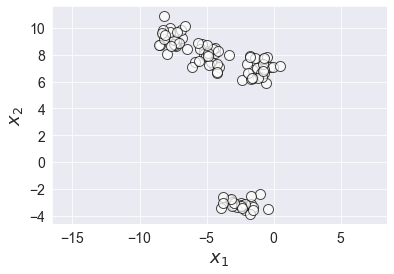

In [6]:
plotting_clusters(X)

## Some `scikit-learn` basics

Now it's time to start to get our hands on the  [`scikit-learn`](https://scikit-learn.org/stable/) package, which is a an open source machine learning library that supports **supervised** and **unsupervised** learning. It also provides various tools for model fitting, data preprocessing, model selection and evaluation, and many other utilities. 

Scikit-learn provides dozens of built-in machine learning algorithms and models, called estimators. Each estimator can be fitted to some data using its fit method.

The fit method generally accepts 2 inputs:

- The samples matrix (or design matrix) $X$. The size of $X$ is typically (n_samples, n_features), which means that samples are represented as rows and features are represented as columns.

- The target values $y$ which are real numbers for regression tasks, or integers for classification (or any other discrete set of values). For unsupervized learning tasks, $y$ does not need to be specified. $y$ is usually 1d array where the $i$-th entry corresponds to the target of the $i$-th sample (row) of $X$.

Both $X$ and $y$ are usually expected to be numpy arrays or equivalent array-like data types (e.g. `pandas` DataFrames), though some estimators work with other formats such as sparse matrices.

Once the estimator is fitted, it can be used for predicting target values of new data (e.g. for classification). 

For further information, have a look at the ["An introduction to machine learning with scikit-learn"](https://scikit-learn.org/stable/tutorial/basic/tutorial.html).

Here is also a [link to a Python Cheat Sheet for `scikit-learn`](https://s3.amazonaws.com/assets.datacamp.com/blog_assets/Scikit_Learn_Cheat_Sheet_Python.pdf).

## *k*-Means Clustering with `scikit-learn`

From now on, we will focus on the *k*-Means algorithm in `scikit-learn`. First, we import the `KMeans` class. Here is a [link](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html#sklearn.cluster.KMeans) to the API documentation of `Kmeans`.

In [7]:
from sklearn.cluster import KMeans

Like already introduced in the previous notebooks, we can also have a quick look at the documentation with the `help` command:

In [8]:
? KMeans

The first input parameter, when we call the KMeans class is the number of clusters $k$ (`n_clusters` keyword). Furthermore, we can see that the initialisation of the $k$-Means algorithm uses the `kmeans++` algorithm, as already discussed in the lecture.

After the Kmeans algorithm is initialized, we use the fit routine to apply it on the data $X$. After that, we can extract the cluster centers and the labels from the attributes of the Kmeans class (attribute `clusters_centers_` and `labels_`, respectively).
Furthermore, the `intertia_` attribute gives us the sum of squared distances of the samples to their closest cluster center ($WCSS$ - *within cluster sum of squares**************************************************************************************), which is the objective function of the kMeans problem that we want to minimize

$$
\sum_{i=1}^{k} \sum_{\mathbf{p} \in \mathbf{S}_i} || \mathbf{p} - \mathbf{\mu}_i ||^2 \ ,
$$
where $\mathbf{S} = \{S_1, S_2, \ldots, S_k\}$ is the partitioning of the samples $\mathbf{p}$ in $k$ clusters, and $\mu_i$ is the  centroid (center of mass) of the cluster $S_i$.

Number of clusters = 10 => WCSS = 34.34


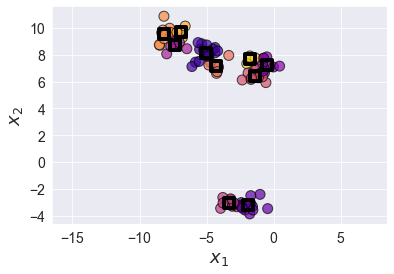

In [15]:
k = 10

km = KMeans(k)
km = km.fit(X)
labels = km.labels_
centers = km.cluster_centers_
wcss = km.inertia_
print(f'Number of clusters = {k} => WCSS = {wcss:.2f}')

plotting_clusters(X, labels=labels, centers=centers)

How should we decide, what is the optimal number of clusters present in the data, or what value should we chose for $k, respectively? 

One possibility is visual inspection, but that is highly subjective. Furthermore, often times the data you’ll be working with will have multiple dimensions making it difficult to visual. As a consequence, the optimum number of clusters $k$ is no longer obvious. Fortunately, we have a way of determining this mathematically, the elbow method...

## Elbow Method
To decide on the optimal number of clusters, we train multiple models using a different $k$ values and storie the value of the WCSS (`intertia_` property) every time.

Of course, this value gets smaller, the more cluster centers are in the data.

In [16]:
wcss = []

c_numbers = np.arange(2, 15)

for k in c_numbers:
    
    km = KMeans(n_clusters=k)
    km = km.fit(X)
    wcss.append(km.inertia_)

wcss = pd.Series(wcss, index=c_numbers)

wcss    

2     681.912569
3     198.104417
4      78.493483
5      66.382727
6      58.374766
7      51.260286
8      44.030385
9      38.665852
10     33.703370
11     30.980323
12     27.471332
13     24.325538
14     22.248472
dtype: float64

But if we graph the relationship between $k$ and WCSS, we see that the change begins at some point to level off, it forms an elbow. This point represents the optimal number of clusters.

Text(0, 0.5, 'WCSS')

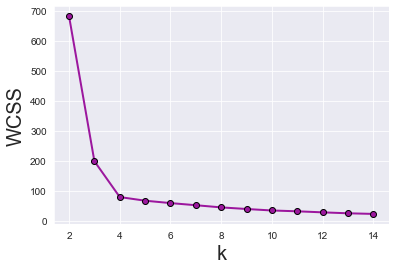

In [17]:
plt.plot(wcss, color=colors[2], linewidth=2, marker='o', markeredgecolor='k')
plt.xlabel('k', fontsize=20)
plt.ylabel('WCSS', fontsize=20)


In the case of the simple example, we identify 4 as the optimal number of clusters. Let's have a look, how the clusters look like in the feature space.

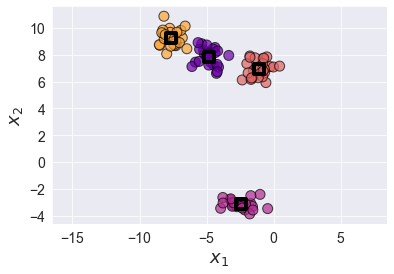

In [18]:
k = 4

km = KMeans(k)
km = km.fit(X)
labels = km.labels_
centers = km.cluster_centers_
plotting_clusters(X, labels=labels, centers=centers)


We see 4 very well separated clusters in the data. Let's have a look at the ground truth of the data:

In [21]:
GT = pd.read_csv('data/multiple_clusters_ground_truth.csv', index_col=0)
GT

,x1,x2,y
0,-7.246391,8.929597,0
1,-2.143058,-3.569374,2
2,-2.243381,-3.296307,2
3,-4.462909,7.213200,1
4,-5.229884,8.357374,1
...,...,...,...
95,-1.388823,7.773271,3
96,-1.707367,-2.501567,2
97,-3.774768,-3.047328,2
98,-1.769790,7.814725,3


In [22]:
cluster_number = len(GT['y'].unique())

print(f'There are {cluster_number} clusters in the data')

There are 4 clusters in the data


Text(0.5, 1.0, 'Ground Truth')

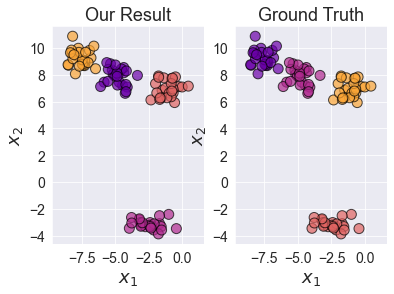

In [23]:
fig, (ax1, ax2) = plt.subplots(1,2)

plt.sca(ax1)
plotting_clusters(X, labels=labels)
ax1.set_title('Our Result', fontsize=18)

plt.sca(ax2)
plotting_clusters(GT[['x1', 'x2']], labels=GT['y'])
ax2.set_title('Ground Truth', fontsize=18)